In [1]:
import os, glob, sqlite3
import numpy
import pandas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [2]:
os.makedirs("Fitness Tracker Dataset", exist_ok=True)
Dataset_Path = os.path.join("Fitness Tracker Dataset", "Fitness Tracker Dataset.csv")

In [3]:
Fitness_Tracker = pandas.read_csv(Dataset_Path)
Fitness_Tracker_SQLite3 = Fitness_Tracker

In [4]:
def Remove_Future(Fitness_Tracker):
    Fitness_Tracker['Datetime'] = pandas.to_datetime(Fitness_Tracker['Datetime'])
    mask = (Fitness_Tracker['Datetime'].dt.year == 2025) | (Fitness_Tracker['Datetime'].dt.year == 2024) & (Fitness_Tracker['Datetime'].dt.month >= 10)
    Fitness_Tracker = Fitness_Tracker[~mask]
    Fitness_Tracker.to_csv(Dataset_Path, index=False)

In [5]:
class SQLite3:
    def __init__(self, Dataset):
        self.Dataset = Dataset
        
    def Data_Statistics(self):
        if 'Fitness Tracker.db' not in glob.glob("*.db"):
            Connection = sqlite3.connect('Fitness Tracker.db')
            self.Dataset.to_sql('Fitness Tracker', Connection, if_exists='replace', index=False)
            print("Database already created!")
            return Connection
        else: return sqlite3.connect('Fitness Tracker.db')

    def Exc(self, Query):
        Connection = self.Data_Statistics()
        return pandas.read_sql_query(Query, Connection)
    
Conn = SQLite3(Fitness_Tracker_SQLite3)
Query = """
    SELECT * 
    FROM 'Fitness Tracker'
"""        
Conn.Exc(Query)

,User ID,Datetime,Steps,Calories Burned,Distance,Activity,Sleep,Heart Rate Avg,Workout Type,Weather Conditions,Location,Mood
0,468,2023-01-01 00:00:00,4530,2543.02,16.10,613,1.5,176,Walking,Clear,Park,Tired
1,879,2023-01-01 00:00:00,11613,1720.76,8.10,352,6.3,128,Cycling,Fog,Park,Happy
2,152,2023-01-01 00:00:00,27335,1706.35,3.57,236,6.7,134,Yoga,Snow,Park,Neutral
3,311,2023-01-01 00:00:00,13459,2912.38,6.41,1329,11.6,116,Swimming,Rain,Office,Tired
4,759,2023-01-01 00:00:00,15378,3344.51,17.88,52,7.4,84,Swimming,Rain,Office,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...
638995,439,2024-09-30 00:00:00,9325,2648.95,5.45,630,11.9,135,Walking,Snow,Other,Stressed
638996,746,2024-09-30 00:00:00,13763,1841.06,14.36,1418,6.8,153,Gym Workout,Clear,Gym,Tired
638997,216,2024-09-30 00:00:00,1549,3773.45,2.79,16,11.6,133,Walking,Snow,Gym,Stressed
638998,218,2024-09-30 00:00:00,7313,2053.57,1.16,218,9.8,60,Gym Workout,Rain,Gym,Happy


In [6]:
class Cleanning_For_Model:
    def __init__(self, Fitness_Tracker):
        self.Dataset = Fitness_Tracker.copy().dropna()
        self.Cleaned_Dataset = self.Data_Cleanning()

    def Data_Cleanning(self):
        for Column_Name in self.Dataset:
            if not pandas.api.types.is_numeric_dtype(self.Dataset[Column_Name]):
                try: 
                    self.Dataset[Column_Name] = self.Dataset[Column_Name].astype(str)
                    Column_Cleanning = {Values: index for index, Values in enumerate(self.Dataset[Column_Name].unique())}
                    self.Dataset.loc[:, Column_Name] = self.Dataset[Column_Name].map(Column_Cleanning).values
                except ValueError:
                    pass
            
        self.Cleaned_Dataset = self.Dataset.drop(['User ID', 'Datetime'], axis=1, errors='ignore')
        return self.Cleaned_Dataset

In [7]:
class Mood_Prediction_Model:
    def __init__(self, Fitness_Tracker):
        self.Data = Cleanning_For_Model(Fitness_Tracker).Cleaned_Dataset    
        self.Model = DecisionTreeClassifier()
        self.Model_Training = self.Model_Training()

    def Model_Training(self):
        X = self.Data.iloc[:, : -1]
        Y = self.Data.iloc[:, -1].astype(int)
        
        Scaler = StandardScaler()
        X = Scaler.fit_transform(X)
        
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)       
        self.Model.fit(X_train, Y_train)
        Y_pred = self.Model.predict(X_test)   
          
        mse = numpy.mean((Y_pred - Y_test) ** 2)  # Tính lỗi bình phương trung bình (MSE)
        print(f"MSE của mô hình: {mse:.2f}")
        print(f"Độ chính xác của mô hình: {self.Model.score(X_test, Y_test) * 100:.2f}%")
        # return mse

Mood_Prediction_Model(Fitness_Tracker).Model_Training

MSE của mô hình: 2.51
Độ chính xác của mô hình: 25.03%


Epoch 1/50
13689/13689 [==============================] - 46s 3ms/step - loss: -746586.8125 - accuracy: 0.2509 - val_loss: -2609544.7500 - val_accuracy: 0.2482
Epoch 2/50
13689/13689 [==============================] - 43s 3ms/step - loss: -7925072.0000 - accuracy: 0.2509 - val_loss: -15687490.0000 - val_accuracy: 0.2482
Epoch 3/50
13689/13689 [==============================] - 43s 3ms/step - loss: -29211234.0000 - accuracy: 0.2509 - val_loss: -46579704.0000 - val_accuracy: 0.2482
Epoch 4/50
13689/13689 [==============================] - 42s 3ms/step - loss: -71616144.0000 - accuracy: 0.2509 - val_loss: -102240520.0000 - val_accuracy: 0.2482
Epoch 5/50
13689/13689 [==============================] - 42s 3ms/step - loss: -142526272.0000 - accuracy: 0.2509 - val_loss: -189949568.0000 - val_accuracy: 0.2482
Epoch 6/50
13689/13689 [==============================] - 45s 3ms/step - loss: -248698256.0000 - accuracy: 0.2509 - val_loss: -316567776.0000 - val_accuracy: 0.2482
Epoch 7/50
13689/1368

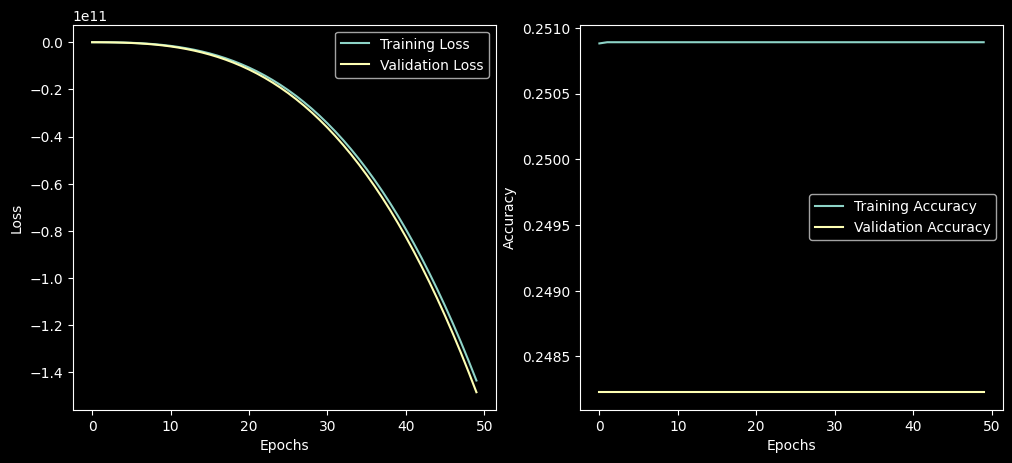

In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

class Cleanning_For_Model:
    def __init__(self, Fitness_Tracker):
        self.Dataset = Fitness_Tracker.copy().dropna()
        self.Cleaned_Dataset = self.Data_Cleanning()

    def Data_Cleanning(self):
        for Column_Name in self.Dataset:
            if not pd.api.types.is_numeric_dtype(self.Dataset[Column_Name]):
                try:
                    self.Dataset[Column_Name] = self.Dataset[Column_Name].astype(str)
                    Column_Cleanning = {Values: index for index, Values in enumerate(self.Dataset[Column_Name].unique())}
                    self.Dataset.loc[:, Column_Name] = self.Dataset[Column_Name].map(Column_Cleanning).values
                except ValueError:
                    pass

        self.Cleaned_Dataset = self.Dataset.drop(['User ID', 'Datetime'], axis=1, errors='ignore')
        return self.Cleaned_Dataset

class Mood_Prediction_Model:
    def __init__(self, Fitness_Tracker):
        self.Data = Cleanning_For_Model(Fitness_Tracker).Cleaned_Dataset
        self.Model = self.Build_Model()
        self.Train_Model()

    def Build_Model(self):
        # Xây dựng mạng neural với Keras
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(self.Data.shape[1] - 1,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')  # Đầu ra nhị phân cho dự đoán mood (0 hoặc 1)
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def Train_Model(self):
        X = self.Data.iloc[:, :-1]
        Y = self.Data.iloc[:, -1].astype(int)

        # Chuẩn hóa dữ liệu
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        # Chia dữ liệu thành tập huấn luyện và kiểm tra
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

        # Huấn luyện mô hình
        history = self.Model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

        # Đánh giá mô hình
        loss, accuracy = self.Model.evaluate(X_test, Y_test, verbose=0)
        print(f'Loss: {loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

        # Vẽ biểu đồ loss và accuracy qua các epoch
        self.Plot_History(history)

    def Plot_History(self, history):
        import matplotlib.pyplot as plt

        plt.figure(figsize=(12, 5))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

# Khởi tạo và huấn luyện mô hình
Mood_Prediction_Model(Fitness_Tracker)
